# Apache Spark Parquet

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

conf = SparkConf()
conf.setMaster('yarn')
conf.setAppName('PySparkGeoMesaGDELT')

sc = SparkContext(conf=conf)
spark = SparkSession(sc)

## Load CAMEO Event Codes

In [12]:
df_codes = pd.read_csv('data/CAMEO.eventcodes.txt', delimiter='\t')
df_codes = df_codes.rename(columns={
    'CAMEOEVENTCODE':   'event_code', 
    'EVENTDESCRIPTION': 'event_description'
})
df_codes['event_code'] = df_codes['event_code'].astype(int)
df_codes['event_description'] = df_codes['event_description'].str.title()
df_codes = df_codes.set_index('event_code')
df_codes.head()

,event_description
event_code,
1,Make Public Statement
10,"Make Statement, Not Specified Below"
11,Decline Comment
12,Make Pessimistic Comment
13,Make Optimistic Comment


In [5]:
%%time
filepath = "hdfs://node-master:54310/user/hadoop/gdelt_parquet_2020/2020.snappy.parq"
parquetDF = spark.read.parquet(filepath)

CPU times: user 5.58 ms, sys: 0 ns, total: 5.58 ms
Wall time: 6.14 s


In [6]:
%%time
parquetDF.count()

CPU times: user 5.78 ms, sys: 3.69 ms, total: 9.47 ms
Wall time: 35 s


24330238

In [9]:
%%time
parquetDF.select('event_date').first()

CPU times: user 10.3 ms, sys: 2.34 ms, total: 12.6 ms
Wall time: 1.97 s


Row(event_date=datetime.datetime(2010, 3, 7, 0, 0))

In [7]:
print(parquetDF.columns)

['event_id', 'event_date', 'event_code', 'event_base_code', 'event_root_code', 'lat', 'lon', 'source_url', 'date']


In [10]:
%%time
df = parquetDF.groupby('event_root_code') \
              .count() \
              .orderBy('count', ascending=False) \
              .toPandas()
df.head()

CPU times: user 24.8 ms, sys: 1.66 ms, total: 26.4 ms
Wall time: 40 s


,event_root_code,count
0,4,5919732
1,1,3617853
2,2,1979791
3,5,1879386
4,3,1640332


In [13]:
df_plot = df.join(df_codes, on='event_root_code', how='left')
df_plot.head()

,event_root_code,count,event_description
0,4,5919732,Consult
1,1,3617853,Make Public Statement
2,2,1979791,Appeal
3,5,1879386,Engage In Diplomatic Cooperation
4,3,1640332,Express Intent To Cooperate


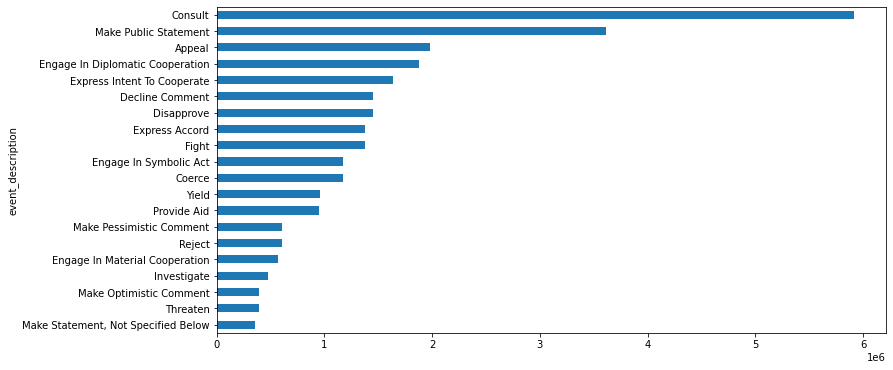

In [14]:
df_plot.set_index('event_description')['count'][:20][::-1].plot(
    kind='barh', figsize=(12, 6));